# Canola Yield: Exploratory and Sequential Analysis on all Regions

## Libraries

In [2]:
import glob

import xarray as xr

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import netCDF4

pd.options.display.max_rows = 1000

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# from standard_precip.spi import SPI
# from standard_precip.utils import plot_index

## Data

In [3]:
df = pd.read_csv('/kaggle/input/rm-yields-data/rm-yields-data.csv')

canola = df[['Year', 'RM', 'Canola']].copy()
canola['Year'] = pd.to_datetime(canola['Year'], format='%Y')

canola.drop(canola.index[:33], inplace=True)

df_pivot = canola.pivot_table(index='Year', columns='RM', values='Canola', aggfunc='mean')

# Count NaN values in each column
na_counts = df_pivot.isna().sum()

# Filter columns with 17 or fewer NaN values
filtered_columns = na_counts[na_counts <= 17].index

# Create a new DataFrame with selected columns
df_filtered = df_pivot[filtered_columns]
df_filtered = df_filtered.drop(index=df_filtered.index[:18])

canola_dist1 = canola[canola['RM'] == 1]

In [4]:
#read dataframe 
canola_2 = pd.read_csv('/kaggle/input/rm-yields-data/rm-yields-data.csv', header=0, index_col=0, parse_dates=True)
canola_small = canola_2.iloc[:, [0, 2]].copy()

#cut of first 33 observations (NAs)
canola_small.drop(canola_small.index[:33], inplace=True)

#filter out every observation that contains NAs
canola_filtered = canola_small.groupby('RM').filter(lambda group: not group['Canola'].isnull().any())

print(canola_filtered)

# how may districts? 148
num_districts = canola_filtered.groupby('RM').ngroups

             RM  Canola
Year                   
1971-01-01    1    18.0
1972-01-01    1    18.0
1973-01-01    1    20.0
1974-01-01    1    16.0
1975-01-01    1    15.0
...         ...     ...
2018-01-01  622    39.3
2019-01-01  622    46.1
2020-01-01  622    40.9
2021-01-01  622    23.9
2022-01-01  622    44.4

[7658 rows x 2 columns]


In [5]:
canola_dist1 = canola_filtered[canola_filtered['RM'] == 1]

#change frequency to yearly 
canola_dist1.index = canola_dist1.index.to_period('A')

#change frequency 
frequency = canola_dist1.index.freq

#print(frequency)

# from sktime.forecasting.trend import PolynomialTrendForecaster

# Quadratic detrending
# forecaster = PolynomialTrendForecaster(degree=1)
# transformer = Detrender(forecaster=forecaster)
# yt = transformer.fit_transform(canola_dist1['Canola'])



# forecaster = PolynomialTrendForecaster(degree=2)
# fh_ins = -np.arange(len(canola_dist1['Canola'])) 
# y_pred = forecaster.fit(canola_dist1['Canola']).predict(fh=fh_ins)

# plot_series(canola_dist1['Canola'], y_pred, yt, labels=["Canola", "fitted quadratic trend", "residuals"]);

In [6]:
%ls /kaggle/input/copernicus-data/*.nc

/kaggle/input/copernicus-data/data_1970.nc
/kaggle/input/copernicus-data/data_1971.nc
/kaggle/input/copernicus-data/data_1972.nc
/kaggle/input/copernicus-data/data_1973.nc
/kaggle/input/copernicus-data/data_1974.nc
/kaggle/input/copernicus-data/data_1975.nc
/kaggle/input/copernicus-data/data_1976.nc
/kaggle/input/copernicus-data/data_1977.nc
/kaggle/input/copernicus-data/data_1978.nc
/kaggle/input/copernicus-data/data_1979.nc
/kaggle/input/copernicus-data/data_1980.nc
/kaggle/input/copernicus-data/data_1981.nc
/kaggle/input/copernicus-data/data_1982.nc
/kaggle/input/copernicus-data/data_1983.nc
/kaggle/input/copernicus-data/data_1984.nc
/kaggle/input/copernicus-data/data_1985.nc
/kaggle/input/copernicus-data/data_1986.nc
/kaggle/input/copernicus-data/data_1987.nc
/kaggle/input/copernicus-data/data_1988.nc
/kaggle/input/copernicus-data/data_1989.nc
/kaggle/input/copernicus-data/data_1990.nc
/kaggle/input/copernicus-data/data_1991.nc
/kaggle/input/copernicus-data/data_1992.nc
/kaggle/inp

In [7]:
cop_all = xr.open_mfdataset(paths='/kaggle/input/copernicus-data/*.nc', combine='by_coords') # , concat_dim="time"?

In [8]:
# use mean of latitude, longitude dims as they only deviate marginally
cop_all.items

<bound method Mapping.items of <xarray.Dataset>
Dimensions:    (longitude: 88, latitude: 41, time: 277344)
Coordinates:
  * longitude  (longitude) float32 -110.0 -109.9 -109.8 ... -101.5 -101.4 -101.3
  * latitude   (latitude) float32 53.0 52.9 52.8 52.7 ... 49.3 49.2 49.1 49.0
  * time       (time) datetime64[ns] 1970-04-01 ... 2023-10-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(5136, 41, 88), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(5136, 41, 88), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-01-22 09:15:12 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...>

In [9]:
cop_all_centralized = cop_all.mean(dim=['latitude', 'longitude'])

cop_all_centralized.items

<bound method Mapping.items of <xarray.Dataset>
Dimensions:  (time: 277344)
Coordinates:
  * time     (time) datetime64[ns] 1970-04-01 ... 2023-10-31T23:00:00
Data variables:
    t2m      (time) float32 dask.array<chunksize=(5136,), meta=np.ndarray>
    tp       (time) float32 dask.array<chunksize=(5136,), meta=np.ndarray>>

In [10]:
column_to_append = canola_dist1['Canola'].tolist()
print(column_to_append)

[18.0, 18.0, 20.0, 16.0, 15.0, 17.0, 17.0, 17.0, 14.0, 6.0, 17.0, 18.0, 17.7, 11.1, 19.4, 21.0, 20.2, 13.0, 8.2, 22.0, 24.1, 15.0, 25.3, 23.1, 15.9, 19.3, 18.1, 26.5, 25.0, 25.3, 22.1, 18.2, 15.9, 23.3, 27.3, 23.3, 22.5, 23.2, 34.2, 27.6, 17.2, 22.3, 32.1, 26.21, 28.65, 32.1, 39.19, 39.2, 32.4, 39.9, 33.2, 37.4]


In [11]:
# dist1_df = cop_all.to_dataframe()

# Resample to weekly frequency and calculate the maximum for each week
weekly_max_t2m = cop_all['t2m'].resample(time='1W').max()

# Print the resulting dataset
print(weekly_max_t2m)

# years = dist1_df.index.year
# dist1_df['Canola'] = [column_to_append[year - 1971] for year in years]

<xarray.DataArray 't2m' (time: 2797, latitude: 41, longitude: 88)>
dask.array<where, shape=(2797, 41, 88), dtype=float32, chunksize=(22, 41, 88), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -110.0 -109.9 -109.8 ... -101.5 -101.4 -101.3
  * latitude   (latitude) float32 53.0 52.9 52.8 52.7 ... 49.3 49.2 49.1 49.0
  * time       (time) datetime64[ns] 1970-04-05 1970-04-12 ... 2023-11-05
Attributes:
    units:      K
    long_name:  2 metre temperature


## Exploratory Analysis

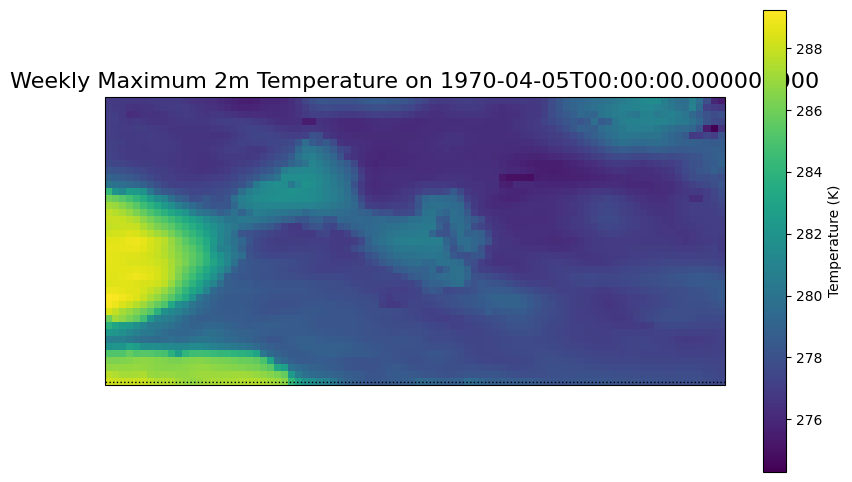

In [12]:
# Choose a specific time index to plot
time_index = 0

# Plotting
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))

# Plot the data
im = weekly_max_t2m.isel(time=time_index).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=False)

# Add coastlines and borders
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label='Temperature (K)')

# Add title
plt.title(f'Weekly Maximum 2m Temperature on {weekly_max_t2m.time.isel(time=time_index).values}', fontsize=16)

plt.show()

In [13]:
# Resample to monthly frequency and calculate the mean for each month
monthly_mean_max_t2m = cop_all['t2m'].resample(time='1M').max()

print(monthly_mean_max_t2m)

<xarray.DataArray 't2m' (time: 643, latitude: 41, longitude: 88)>
dask.array<where, shape=(643, 41, 88), dtype=float32, chunksize=(6, 41, 88), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -110.0 -109.9 -109.8 ... -101.5 -101.4 -101.3
  * latitude   (latitude) float32 53.0 52.9 52.8 52.7 ... 49.3 49.2 49.1 49.0
  * time       (time) datetime64[ns] 1970-04-30 1970-05-31 ... 2023-10-31
Attributes:
    units:      K
    long_name:  2 metre temperature


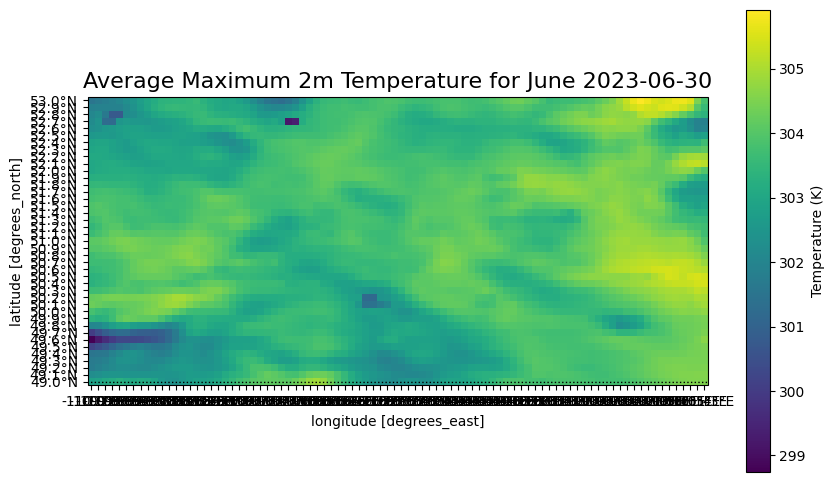

In [14]:
# Choose a specific June for the plot
target_june = '2023-06-30'  # Adjust the date accordingly

# Plotting
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))

# Plot the data for the specific June
im = monthly_mean_max_t2m.sel(time=target_june).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=False)

# Add coastlines and borders
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label='Temperature (K)')

# Add title
plt.title(f'Average Maximum 2m Temperature for June {target_june}', fontsize=16)

# Add latitude and longitude indices
ax.set_xticks(monthly_mean_max_t2m.longitude.values)
ax.set_yticks(monthly_mean_max_t2m.latitude.values)
ax.xaxis.set_major_formatter('{:.1f}°E'.format)
ax.yaxis.set_major_formatter('{:.1f}°N'.format)

plt.show()

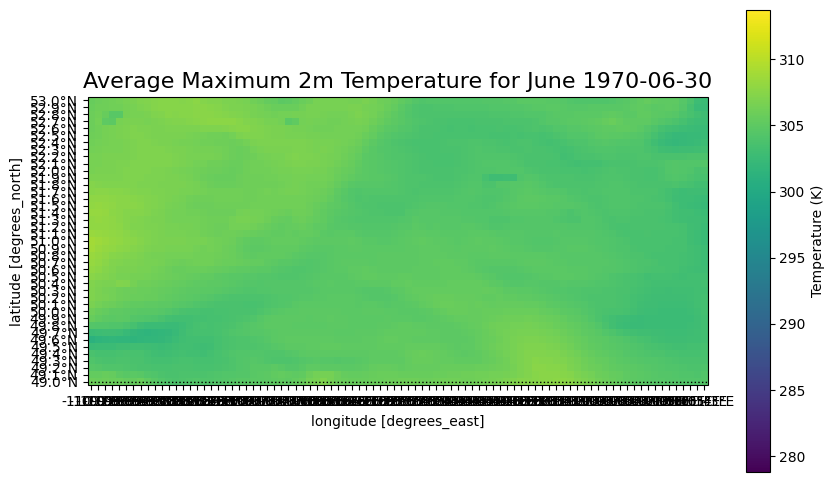

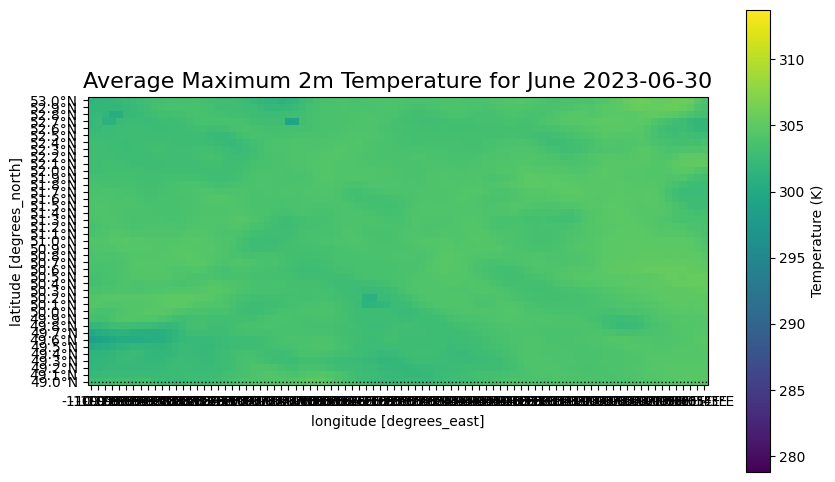

In [15]:
# Specify the target Junes
target_june_1970 = '1970-06-30'
target_june_2023 = '2023-06-30'

# Calculate a common vmin and vmax for both plots
common_vmin = monthly_mean_max_t2m.min().values
common_vmax = monthly_mean_max_t2m.max().values

# Plotting for 1970 June
fig, ax1 = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))
im1 = monthly_mean_max_t2m.sel(time=target_june_1970).plot.pcolormesh(ax=ax1, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=False, vmin=common_vmin, vmax=common_vmax)
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.set_xticks(monthly_mean_max_t2m.longitude.values)
ax1.set_yticks(monthly_mean_max_t2m.latitude.values)
ax1.xaxis.set_major_formatter('{:.1f}°E'.format)
ax1.yaxis.set_major_formatter('{:.1f}°N'.format)
cbar1 = plt.colorbar(im1, ax=ax1, label='Temperature (K)')
plt.title(f'Average Maximum 2m Temperature for June {target_june_1970}', fontsize=16)

# Plotting for 2023 June
fig, ax2 = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))
im2 = monthly_mean_max_t2m.sel(time=target_june_2023).plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=False, vmin=common_vmin, vmax=common_vmax)
ax2.coastlines()
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.set_xticks(monthly_mean_max_t2m.longitude.values)
ax2.set_yticks(monthly_mean_max_t2m.latitude.values)
ax2.xaxis.set_major_formatter('{:.1f}°E'.format)
ax2.yaxis.set_major_formatter('{:.1f}°N'.format)
cbar2 = plt.colorbar(im2, ax=ax2, label='Temperature (K)')
plt.title(f'Average Maximum 2m Temperature for June {target_june_2023}', fontsize=16)

plt.show()

In [16]:
t2m_monthly_avg_max = monthly_mean_max_t2m.to_dataframe()

# Display the resulting DataFrame
print(t2m_monthly_avg_max)

                                        t2m
time       latitude longitude              
1970-04-30 53.0     -110.000000  287.790710
                    -109.900002  287.745758
                    -109.800003  287.660004
                    -109.699997  287.575928
                    -109.599998  287.571747
...                                     ...
2023-10-31 49.0     -101.699997  292.968170
                    -101.599998  293.057922
                    -101.500000  293.128998
                    -101.400002  293.200989
                    -101.300003  293.236511

[2319944 rows x 1 columns]


In [17]:
monthly_total_precipitation = cop_all['tp'].resample(time='1M').sum()
monthly_total_precipitation_df = monthly_total_precipitation.to_dataframe()

In [18]:
print(monthly_total_precipitation_df)

                                       tp
time       latitude longitude            
1970-04-30 53.0     -110.000000  0.128606
                    -109.900002  0.139182
                    -109.800003  0.144129
                    -109.699997  0.135399
                    -109.599998  0.123538
...                                   ...
2023-10-31 49.0     -101.699997  0.708551
                    -101.599998  0.701376
                    -101.500000  0.693851
                    -101.400002  0.686369
                    -101.300003  0.680388

[2319944 rows x 1 columns]


In [19]:
# Combine the two DataFrames along the columns axis
combined_df = pd.concat([t2m_monthly_avg_max, monthly_total_precipitation_df], axis=1)

# Display the resulting DataFrame
print(combined_df)

                                        t2m        tp
time       latitude longitude                        
1970-04-30 53.0     -110.000000  287.790710  0.128606
                    -109.900002  287.745758  0.139182
                    -109.800003  287.660004  0.144129
                    -109.699997  287.575928  0.135399
                    -109.599998  287.571747  0.123538
...                                     ...       ...
2023-10-31 49.0     -101.699997  292.968170  0.708551
                    -101.599998  293.057922  0.701376
                    -101.500000  293.128998  0.693851
                    -101.400002  293.200989  0.686369
                    -101.300003  293.236511  0.680388

[2319944 rows x 2 columns]


In [20]:
combined_df.head

<bound method NDFrame.head of                                         t2m        tp
time       latitude longitude                        
1970-04-30 53.0     -110.000000  287.790710  0.128606
                    -109.900002  287.745758  0.139182
                    -109.800003  287.660004  0.144129
                    -109.699997  287.575928  0.135399
                    -109.599998  287.571747  0.123538
...                                     ...       ...
2023-10-31 49.0     -101.699997  292.968170  0.708551
                    -101.599998  293.057922  0.701376
                    -101.500000  293.128998  0.693851
                    -101.400002  293.200989  0.686369
                    -101.300003  293.236511  0.680388

[2319944 rows x 2 columns]>

In [21]:
# Extract features (t2m and tp) for clustering
features = combined_df[['t2m', 'tp']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
features_scaled_imputed = imputer.fit_transform(features_scaled)

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
combined_df['cluster'] = kmeans.fit_predict(features_scaled_imputed)

# Display the resulting DataFrame with clusters
print(combined_df)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasatt

                                        t2m        tp  cluster
time       latitude longitude                                 
1970-04-30 53.0     -110.000000  287.790710  0.128606        1
                    -109.900002  287.745758  0.139182        1
                    -109.800003  287.660004  0.144129        1
                    -109.699997  287.575928  0.135399        1
                    -109.599998  287.571747  0.123538        1
...                                     ...       ...      ...
2023-10-31 49.0     -101.699997  292.968170  0.708551        1
                    -101.599998  293.057922  0.701376        1
                    -101.500000  293.128998  0.693851        1
                    -101.400002  293.200989  0.686369        1
                    -101.300003  293.236511  0.680388        1

[2319944 rows x 3 columns]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


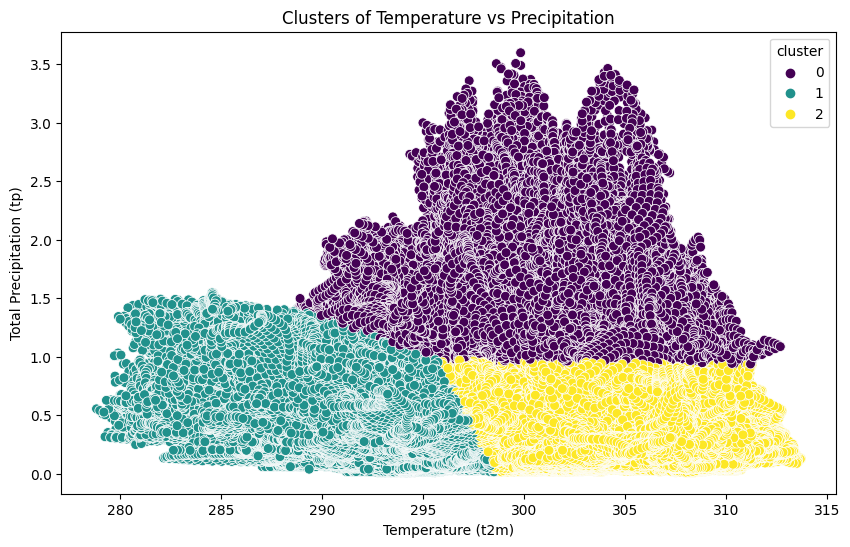

In [22]:
# Scatter plot for temperature vs precipitation, color-coded by clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='t2m', y='tp', hue='cluster', data=combined_df, palette='viridis', s=50)
plt.title('Clusters of Temperature vs Precipitation')
plt.xlabel('Temperature (t2m)')
plt.ylabel('Total Precipitation (tp)')
plt.show()

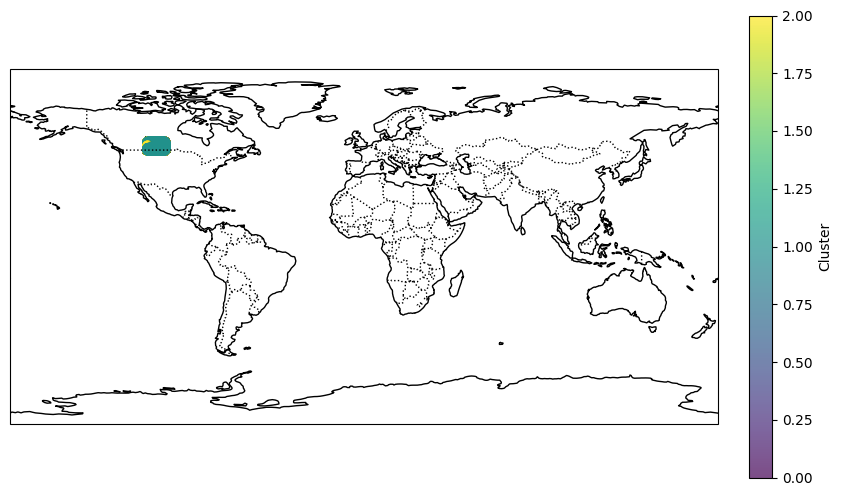

In [23]:
# Create a Cartopy map with a PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90])  # Set the map extent

# Add countries as a background feature
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Scatter plot for each data point with color-coded clusters
sc = ax.scatter(combined_df.index.get_level_values('longitude'), combined_df.index.get_level_values('latitude'),
                c=combined_df['cluster'], cmap='viridis', s=50, alpha=0.7, transform=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, label='Cluster')

# Display the map
plt.show()

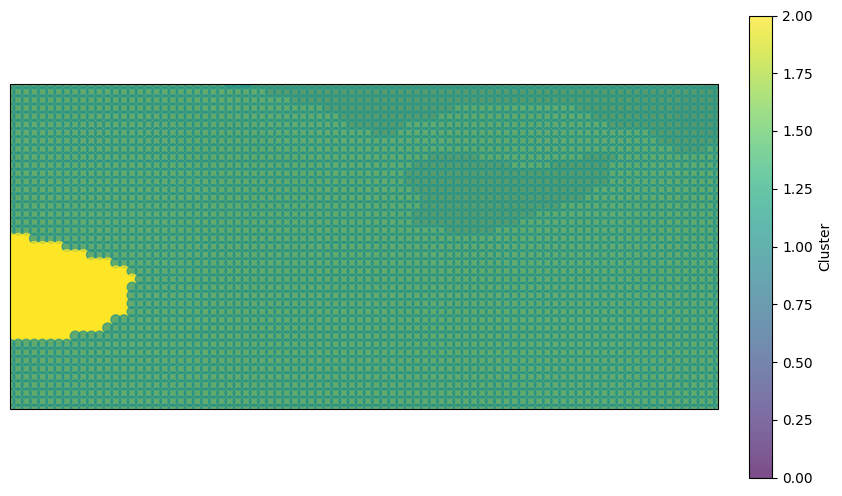

In [24]:
# Extract latitude and longitude ranges from your data
min_lat, max_lat = combined_df.index.get_level_values('latitude').min(), combined_df.index.get_level_values('latitude').max()
min_lon, max_lon = combined_df.index.get_level_values('longitude').min(), combined_df.index.get_level_values('longitude').max()

# Create a Cartopy map with a PlateCarree projection and set the map extent
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([min_lon, max_lon, min_lat, max_lat])

# Add countries as a background feature
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Scatter plot for each data point with color-coded clusters
sc = ax.scatter(combined_df.index.get_level_values('longitude'), combined_df.index.get_level_values('latitude'),
                c=combined_df['cluster'], cmap='viridis', s=50, alpha=0.7, transform=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, label='Cluster')

# Display the map
plt.show()

In [25]:
# NOT WORKING YET

def calculate_spi(precipitation_values):
    # Extract month from the multi-level index
    months = precipitation_values.index.get_level_values('time').month
    
    # Your SPI calculation logic here
    # For example, using gamma distribution fitting:
    params = gamma.fit(precipitation_values, loc=0)
    cdf = gamma.cdf(precipitation_values, *params)
    spi_values = gamma.ppf(cdf, *params)
    
    return spi_values

# Ensure the 'tp' column is numeric (it may be an object dtype after concatenation)
# combined_df['tp'] = pd.to_numeric(combined_df['tp'], errors='coerce')

# Apply the SPI calculation
# combined_df['SPI'] = combined_df['tp'].groupby(months).transform(calculate_spi)

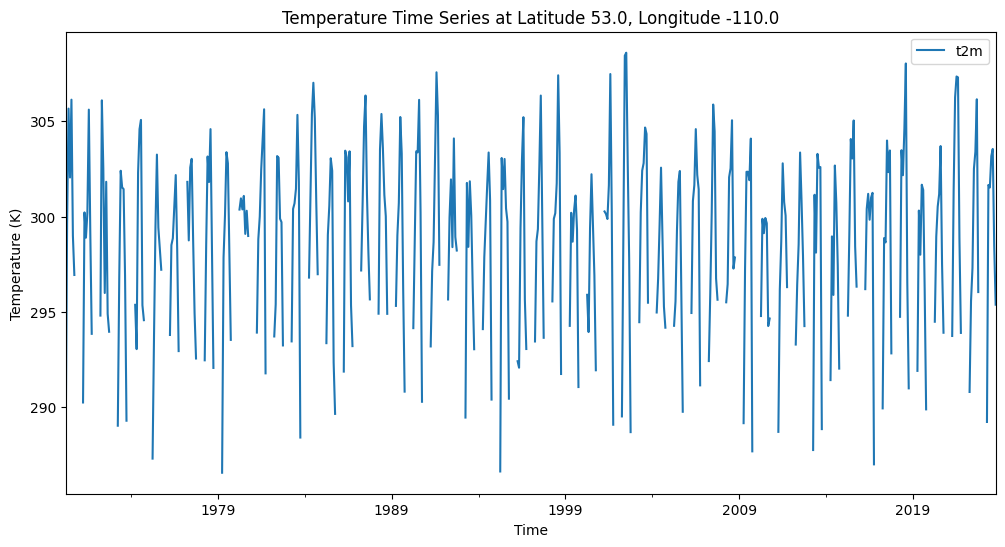

In [26]:
selected_location = t2m_monthly_avg_max.xs((53.0, -110.0), level=('latitude', 'longitude'))
selected_location.plot(figsize=(12, 6), title='Temperature Time Series at Latitude 53.0, Longitude -110.0')
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.show()

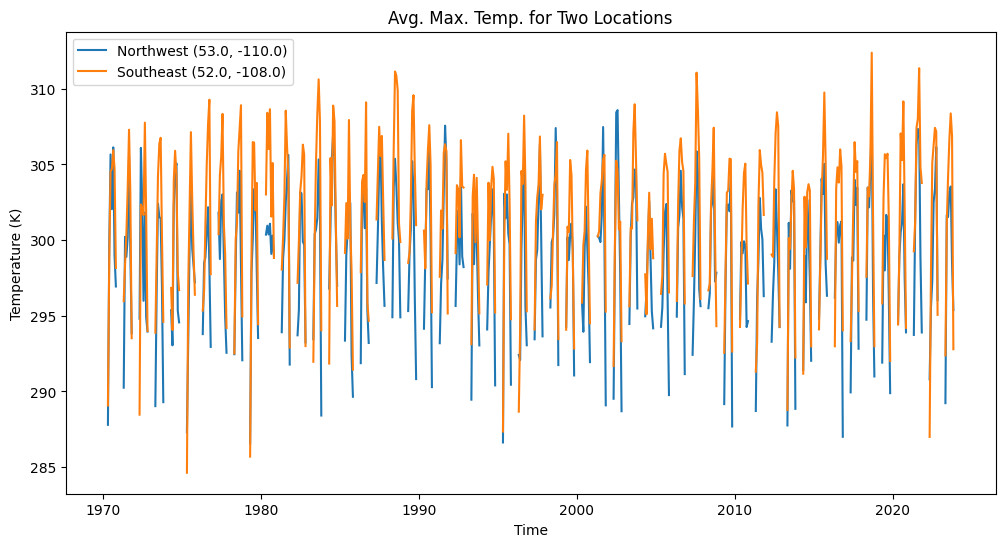

In [27]:
# Select data for two locations
location1 = t2m_monthly_avg_max.xs((53.0, -110.0), level=('latitude', 'longitude'))
location2 = t2m_monthly_avg_max.xs((49.0, -102.0), level=('latitude', 'longitude'))

# Plot time series for both locations
plt.figure(figsize=(12, 6))
plt.plot(location1.index.get_level_values('time'), location1['t2m'], label='Northwest (53.0, -110.0)')
plt.plot(location2.index.get_level_values('time'), location2['t2m'], label='Southeast (52.0, -108.0)')

plt.title('Avg. Max. Temp. for Two Locations')
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

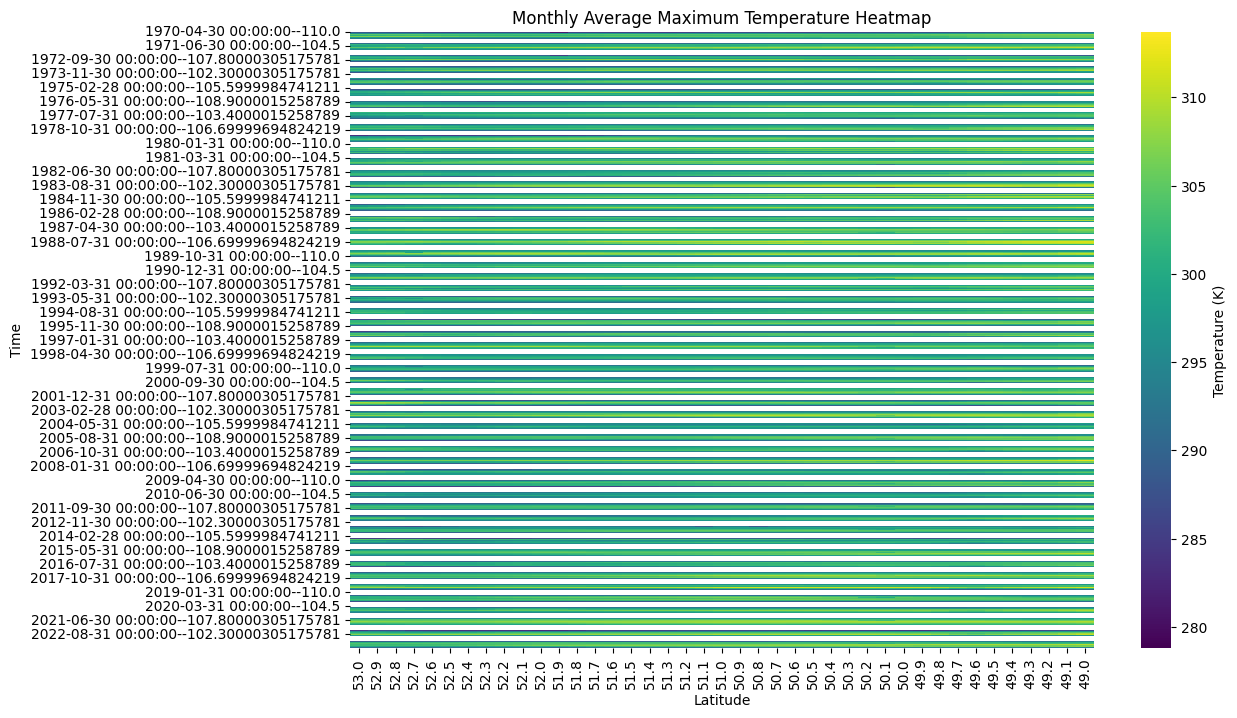

In [28]:
# Assuming 't2m_monthly_avg_max' is your DataFrame

# Reshape the DataFrame for heatmap
heatmap_data = t2m_monthly_avg_max.unstack(level='latitude')['t2m']

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': 'Temperature (K)'})
plt.title('Monthly Average Maximum Temperature Heatmap')
plt.xlabel('Latitude')
plt.ylabel('Time')
plt.show()

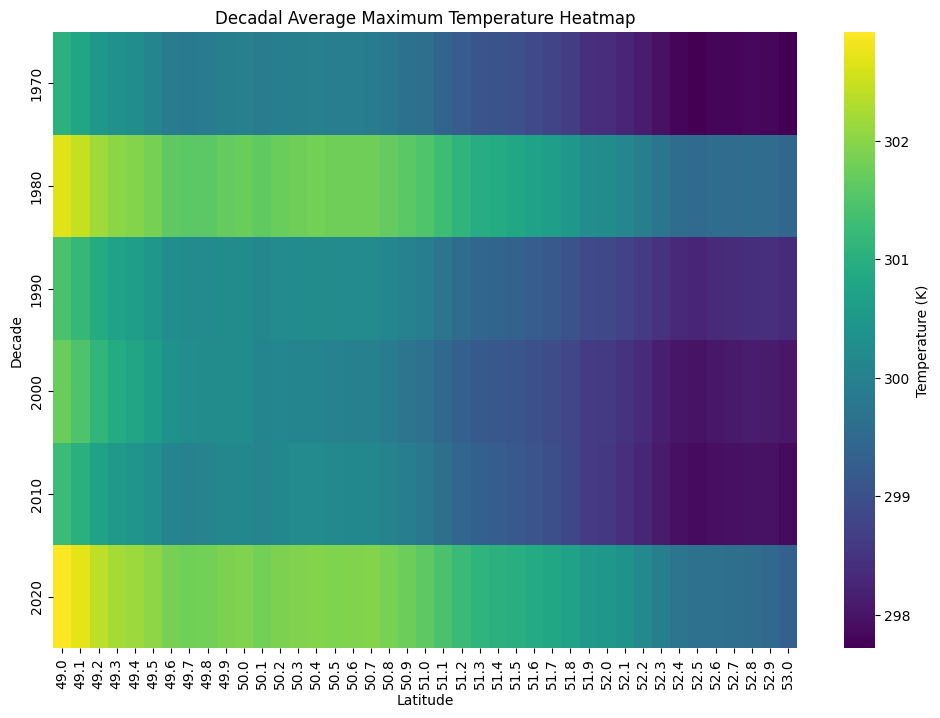

In [29]:
# Assuming 't2m_monthly_avg_max' is your DataFrame

# Extract decade from the 'time' index
t2m_monthly_avg_max['decade'] = (t2m_monthly_avg_max.index.get_level_values('time').year // 10) * 10

# Group by decade and latitude, then calculate the mean
heatmap_data_decade = t2m_monthly_avg_max.groupby(['decade', 'latitude']).mean()['t2m'].unstack()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_decade, cmap='viridis', cbar_kws={'label': 'Temperature (K)'})
plt.title('Decadal Average Maximum Temperature Heatmap')
plt.xlabel('Latitude')
plt.ylabel('Decade')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


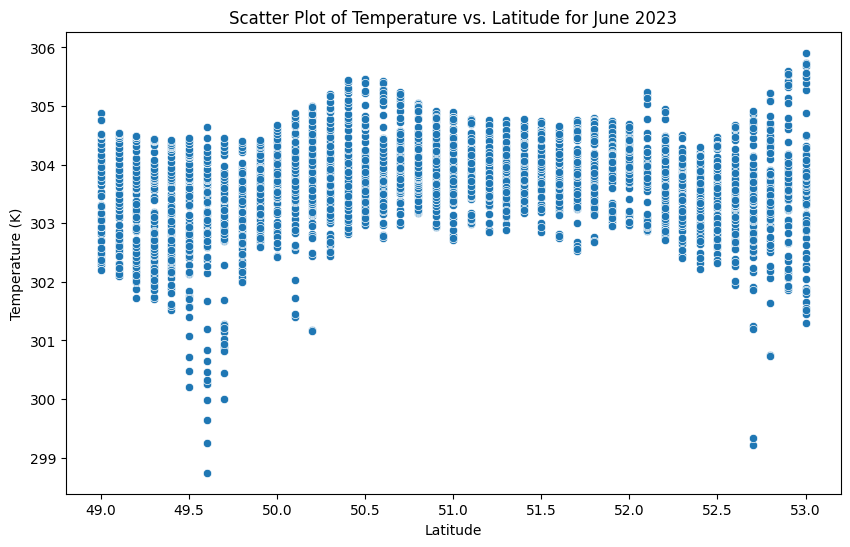

In [30]:
# Scatter plot between latitude and temperature for a specific month (e.g., '2023-06-30')
selected_month = t2m_monthly_avg_max.xs('2023-06-30', level='time')
plt.figure(figsize=(10, 6))
sns.scatterplot(x=selected_month.index.get_level_values('latitude'), y=selected_month['t2m'])
plt.title('Scatter Plot of Temperature vs. Latitude for June 2023')
plt.xlabel('Latitude')
plt.ylabel('Temperature (K)')
plt.show()

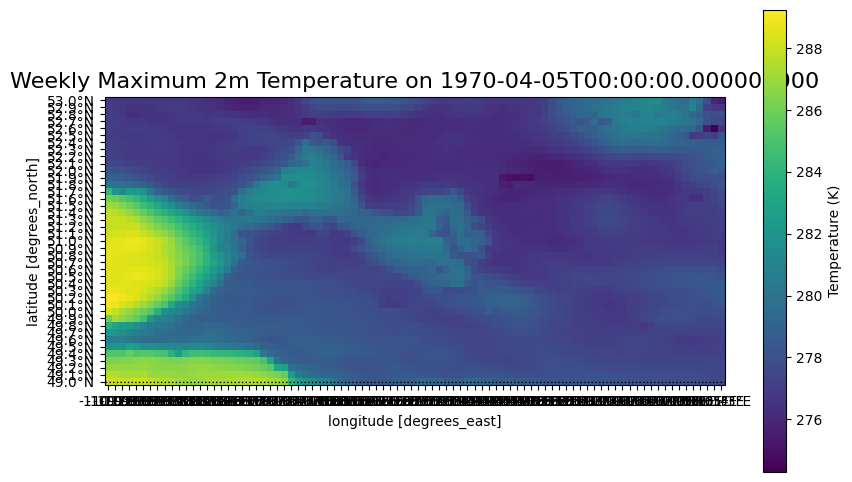

In [31]:
# Assuming 'weekly_max_t2m' is your resulting dataset

# Choose a specific time index to plot
time_index = 0

# Plotting
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))

# Plot the data
im = weekly_max_t2m.isel(time=time_index).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=False)

# Add coastlines and borders
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label='Temperature (K)')

# Add title
plt.title(f'Weekly Maximum 2m Temperature on {weekly_max_t2m.time.isel(time=time_index).values}', fontsize=16)

# Add latitude and longitude indices
ax.set_xticks(weekly_max_t2m.longitude.values)
ax.set_yticks(weekly_max_t2m.latitude.values)
ax.xaxis.set_major_formatter('{:.1f}°E'.format)
ax.yaxis.set_major_formatter('{:.1f}°N'.format)

plt.show()

## Sequential Analysis: Heat and Drought Phases

In [ ]:
# "Heat Phase": no. of occurrences of 5 (?) consecutive days above 300 degrees Kelvin

# CA drought monitor: https://agriculture.canada.ca/en/agricultural-production/weather/canadian-drought-monitor
# drought classes by SPI: https://droughtmonitor.unl.edu/About/AbouttheData/DroughtClassification.aspx

In [32]:
# Set the temperature threshold for defining heat phases
temperature_threshold = 300  # Adjust this threshold as needed

# Create a binary mask for values above the threshold
heat_mask = combined_df['t2m'] > temperature_threshold

# Identify consecutive True sequences (heat phases)
heat_phases = (heat_mask.astype(int).groupby((~heat_mask).cumsum()).cumsum() * heat_mask).groupby(level=0).max()

# Display the identified heat phases
print(heat_phases)

time
1970-04-30        0
1970-05-31       21
1970-06-30     3608
1970-07-31     7216
1970-08-31    10824
1970-09-30     1527
1970-10-31       33
1970-11-30        0
1970-12-31        0
1971-01-31        0
1971-02-28        0
1971-03-31        0
1971-04-30        0
1971-05-31       87
1971-06-30       87
1971-07-31     1496
1971-08-31     5104
1971-09-30     1496
1971-10-31        8
1971-11-30        0
1971-12-31        0
1972-01-31        0
1972-02-29        0
1972-03-31        0
1972-04-30        0
1972-05-31      527
1972-06-30     3031
1972-07-31      611
1972-08-31     4219
1972-09-30       45
1972-10-31        0
1972-11-30        0
1972-12-31        0
1973-01-31        0
1973-02-28        0
1973-03-31        0
1973-04-30        0
1973-05-31       13
1973-06-30     2298
1973-07-31     2045
1973-08-31     3168
1973-09-30        9
1973-10-31        0
1973-11-30        0
1973-12-31        0
1974-01-31        0
1974-02-28        0
1974-03-31        0
1974-04-30        5
1974-05-31     

In [33]:
# Set the precipitation threshold for defining drought phases
precipitation_threshold = 1  # Adjust this threshold as needed

# Create a binary mask for values below the precipitation threshold
drought_mask = combined_df['tp'] < precipitation_threshold

# Identify consecutive True sequences (drought phases)
drought_phases = (drought_mask.astype(int).groupby((~drought_mask).cumsum()).cumsum() * drought_mask).groupby(level=0).max()

# Display the identified drought phases
print(drought_phases)

time
1970-04-30       77
1970-05-31     2526
1970-06-30       64
1970-07-31       78
1970-08-31     3608
1970-09-30     5171
1970-10-31     3168
1970-11-30        0
1970-12-31        0
1971-01-31        0
1971-02-28        0
1971-03-31        0
1971-04-30     3079
1971-05-31     3519
1971-06-30       57
1971-07-31       84
1971-08-31     3656
1971-09-30     7264
1971-10-31     9635
1971-11-30        0
1971-12-31        0
1972-01-31        0
1972-02-29        0
1972-03-31        0
1972-04-30     3608
1972-05-31     4986
1972-06-30     1060
1972-07-31     1948
1972-08-31     3168
1972-09-30     5819
1972-10-31     3679
1972-11-30        0
1972-12-31        0
1973-01-31        0
1973-02-28        0
1973-03-31        0
1973-04-30     1478
1973-05-31     3187
1973-06-30       53
1973-07-31      879
1973-08-31      180
1973-09-30      349
1973-10-31     3608
1973-11-30        0
1973-12-31        0
1974-01-31        0
1974-02-28        0
1974-03-31        0
1974-04-30     3608
1974-05-31     

ValueError: where size (643) does not match x size (2319944)

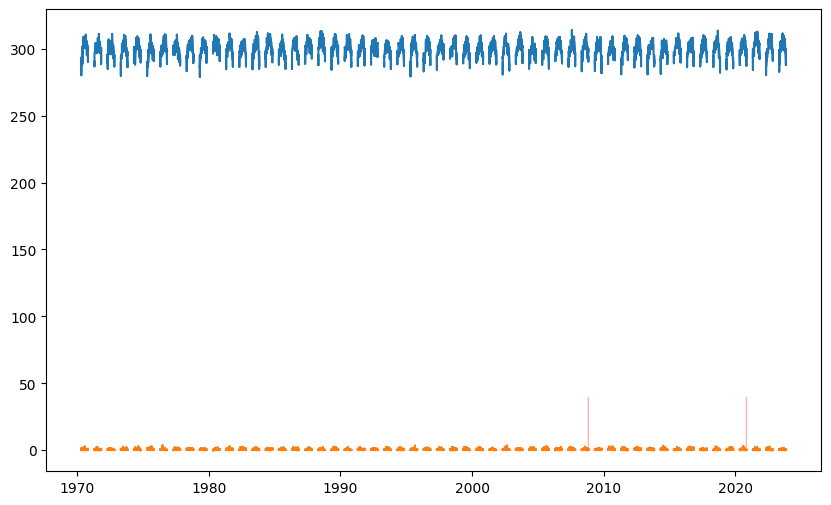

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(combined_df.index.get_level_values('time'), combined_df['t2m'], label='Temperature')
plt.plot(combined_df.index.get_level_values('time'), combined_df['tp'], label='Precipitation')

# Create a mask for heat phases with the same length as the time series data
heat_phases_mask = np.repeat(heat_phases.values, len(combined_df) // len(heat_phases))

# Highlight heat phases
plt.fill_between(combined_df.index.get_level_values('time'), 0, 40, where=heat_phases_mask == 1, color='red', alpha=0.3, label='Heat Phase')

# Highlight drought phases
plt.fill_between(combined_df.index.get_level_values('time'), 0, 40, where=drought_phases == 1, color='orange', alpha=0.3, label='Drought Phase')

plt.xlabel('Time')
plt.ylabel('Temperature / Precipitation')
plt.legend()
plt.show()